In [1]:
# imports
from Utils.Imports import *
from Utils.ModelWrapper import ModelWrapper

# models
from Models.BuildEncoder import BuildEncoder
from Models.BuildDecoder import BuildDecoder

In [2]:
device = torch.device(GetLowestGPU())

Device set to cuda:1


# Data loading

In [3]:
path = '../../Data/VirtualPopulations/TumorHet/'

# load training data 
images = np.load(path + 'images.npy')
times = np.load(path + 'times.npy')

In [4]:
# 0/1 normalize
img_min = np.min(images)
images -= img_min
img_max = np.max(images)
images /= img_max

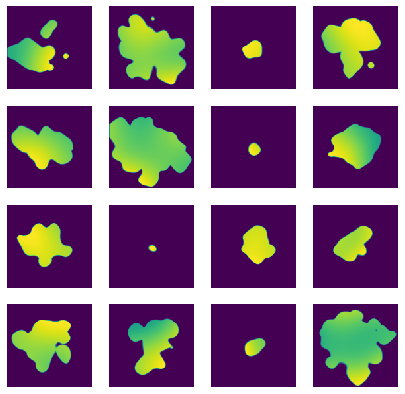

In [5]:
# split into training and validation sets
p = np.random.permutation(len(images))
split = int(0.8 * len(images))
train_images = images[p[:split]]
train_labels = times[p[:split]]
val_images = images[p[split:]]
val_labels = times[p[split:]]

# convert to torch tensors
train_images = torch.from_numpy(train_images).float().to(device)
train_labels = torch.from_numpy(train_labels).float().to(device)
val_images = torch.from_numpy(val_images).float().to(device)
val_labels = torch.from_numpy(val_labels).float().to(device)

# plot random examples
fig = plt.figure(figsize=(7,7))
for i in range(16):
    rand_idx = np.random.choice(len(val_images))
    input = val_images[rand_idx].detach().cpu().numpy()
    input = np.squeeze(input)
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(input)
    plt.axis('off')
    plt.axis('tight')
plt.show()

In [6]:
latent_dim = 100
layers = [16, 32, 64, 128, 256]
image_shape = (1, 128, 128)
final_shape = int(image_shape[1] / (2**len(layers)))

class VAE(nn.Module):
   
    def __init__(self):
        
        super().__init__()
        self.image_shape = image_shape
        encoder_input = list(image_shape)
        
        self.encoder = BuildEncoder(
            input_shape=encoder_input,
            latent_dim=2*latent_dim,
            layers=layers,
            activation=nn.ELU(),
            addl_convs=0,
            use_batchnorm=True)
        
        self.decoder = BuildDecoder(
            latent_dim=latent_dim,
            init_shape=[layers[-1], final_shape, final_shape],
            layers=layers[::-1],
            output_channels=image_shape[0],
            activation=nn.ELU(),
            addl_convs=0,
            use_batchnorm=True)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.device = device
        
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        
        return z
    
    def encode(self, x):
        
        x = self.encoder(x).view(len(x), 2, -1)
        self.mu = x[:, 0, :]
        self.logvar = x[:, 1, :]
        
        return self.mu, self.logvar
    
    def forward(self, x):
        
        self.mu, self.logvar = self.encode(x)
        self.z = self.reparameterize(self.mu, self.logvar)
        reconstruction = self.decoder(self.z)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction

In [7]:
# define model and optimizer
vae = VAE().to(device)
opt = torch.optim.Adam(vae.parameters(), lr=0.0001, betas=(0.9, 0.999))

# loss weights for [mse, kld]
weights = [1.0, 1e-4]

# mse loss
MSE = nn.MSELoss()
def mse_loss(pred, true):
    return weights[0]*MSE(pred, true)

# kld loss
def KLD(mu, logvar): # https://arxiv.org/abs/1312.6114
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
def kld_loss(model, input, true, pred):
    return weights[1]*KLD(model.mu, model.logvar)

# random 90 degree rotation
def augment(x, y):
    r = np.random.choice(4)
    return x.rot90(r, dims=[2,3]), y.rot90(r, dims=[2,3])

# wrap model for easy training
model = ModelWrapper(
    model=vae,
    optimizer=opt,
    loss=mse_loss,
    regularizer=kld_loss,
    save_name='Weights/vae',
    save_best_train=False,
    save_best_val=True,
    save_opt=True)

In [8]:
epochs = 5000
batch_size = 64

model.fit(
    x=train_images,
    y=train_images,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(val_images, val_images),
    shuffle=True,
    initial_epoch=0,
    inline_augment=augment,
    best_val_loss=np.inf)

Epoch 4999 | Train loss = 2.7524e-03 | Val loss = 2.1785e-03 | Elapsed = 3:05:09             


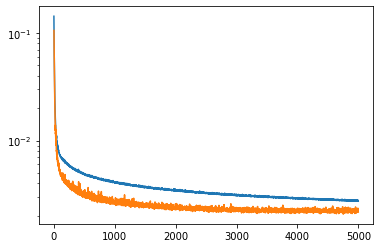

In [9]:
plt.semilogy(model.train_loss_list)
plt.semilogy(model.val_loss_list)
plt.show()

In [10]:
model.load_best_val(device=device)

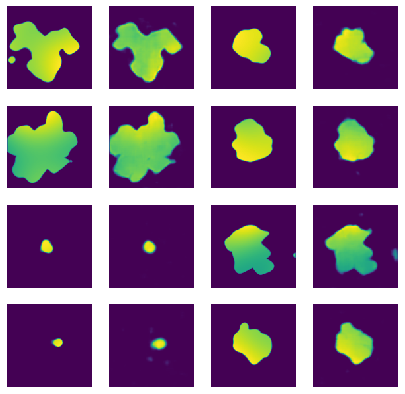

In [11]:
fig = plt.figure(figsize=(7,7))
for i in range(8):
    rand_idx = np.random.choice(len(val_images))
    input = val_images[rand_idx][None]
    reconstruction = model.model(input).detach().cpu().numpy()
    
    ax = fig.add_subplot(4, 4, 2*i+1)
    original = input.detach().cpu().numpy()
    plt.imshow(np.squeeze(original))
    plt.axis('off')
    plt.axis('tight')
    
    ax = fig.add_subplot(4, 4, 2*i+2)
    plt.imshow(np.squeeze(reconstruction))
    plt.axis('off')
    plt.axis('tight')
plt.show()